# Benchmarking performance for image morphing 

In [29]:
# Import libraries

import subprocess
import numpy as np
import pandas as pd
import matplotlib
from   matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy

In [52]:
# Setup for plotting
sns.set(style='darkgrid')
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (10, 5)

In [41]:
# Run this cell after building source with OpenMP support enabled

parallel_outputs = []

for dropout in tqdm(np.arange(0.0, 1.05, 0.05)):
    output_string = None
    for _ in range(5):
        output_string = subprocess.run(f'bash benchmark.sh {dropout}', 
            capture_output=True, shell=True).stdout.decode('utf-8')
        parallel_outputs.append(output_string)

100%|██████████| 21/21 [11:05<00:00, 31.67s/it]


In [42]:
# Run this cell after building source with OpenMP support disabled

serial_outputs = []

for dropout in tqdm(np.arange(0.0, 1.05, 0.05)):
    output_string = None
    for _ in range(5):
        output_string = subprocess.run(f'bash benchmark.sh {dropout}', 
            capture_output=True, shell=True).stdout.decode('utf-8')
        serial_outputs.append(output_string)

100%|██████████| 21/21 [22:16<00:00, 63.65s/it]


In [43]:
def parse(output_string):
    """Parse the output of the process to extract performance statistics
    :param output_string: output generated by the process
    """
    lines = output_string.split('\n')[:-1]
    n_points = []
    n_triangles = []
    elapsed_times = []
    for line in lines:
        words = line.split()
        elapsed_times.append(float(words[4].rstrip('ms')))
        n_points.append(int(words[-3].rstrip(']')))
        n_triangles.append(int(words[-1].rstrip(']')))
    return n_points, n_triangles, elapsed_times

In [44]:
data = {
    'n_points': [],
    'n_triangles': [],
    'elapsed_time': [],
    'execution_type': []
}

In [45]:
for output_string in parallel_outputs:
    n_points, n_triangles, elapsed_times = parse(output_string)
    for i in range(len(n_points)):
        data['n_points'].append(n_points[i])
        data['n_triangles'].append(n_triangles[i])
        data['elapsed_time'].append(elapsed_times[i])
        data['execution_type'].append('parallel')

In [46]:
for output_string in serial_outputs:
    n_points, n_triangles, elapsed_times = parse(output_string)
    for i in range(len(n_points)):
        data['n_points'].append(n_points[i])
        data['n_triangles'].append(n_triangles[i])
        data['elapsed_time'].append(elapsed_times[i])
        data['execution_type'].append('serial')

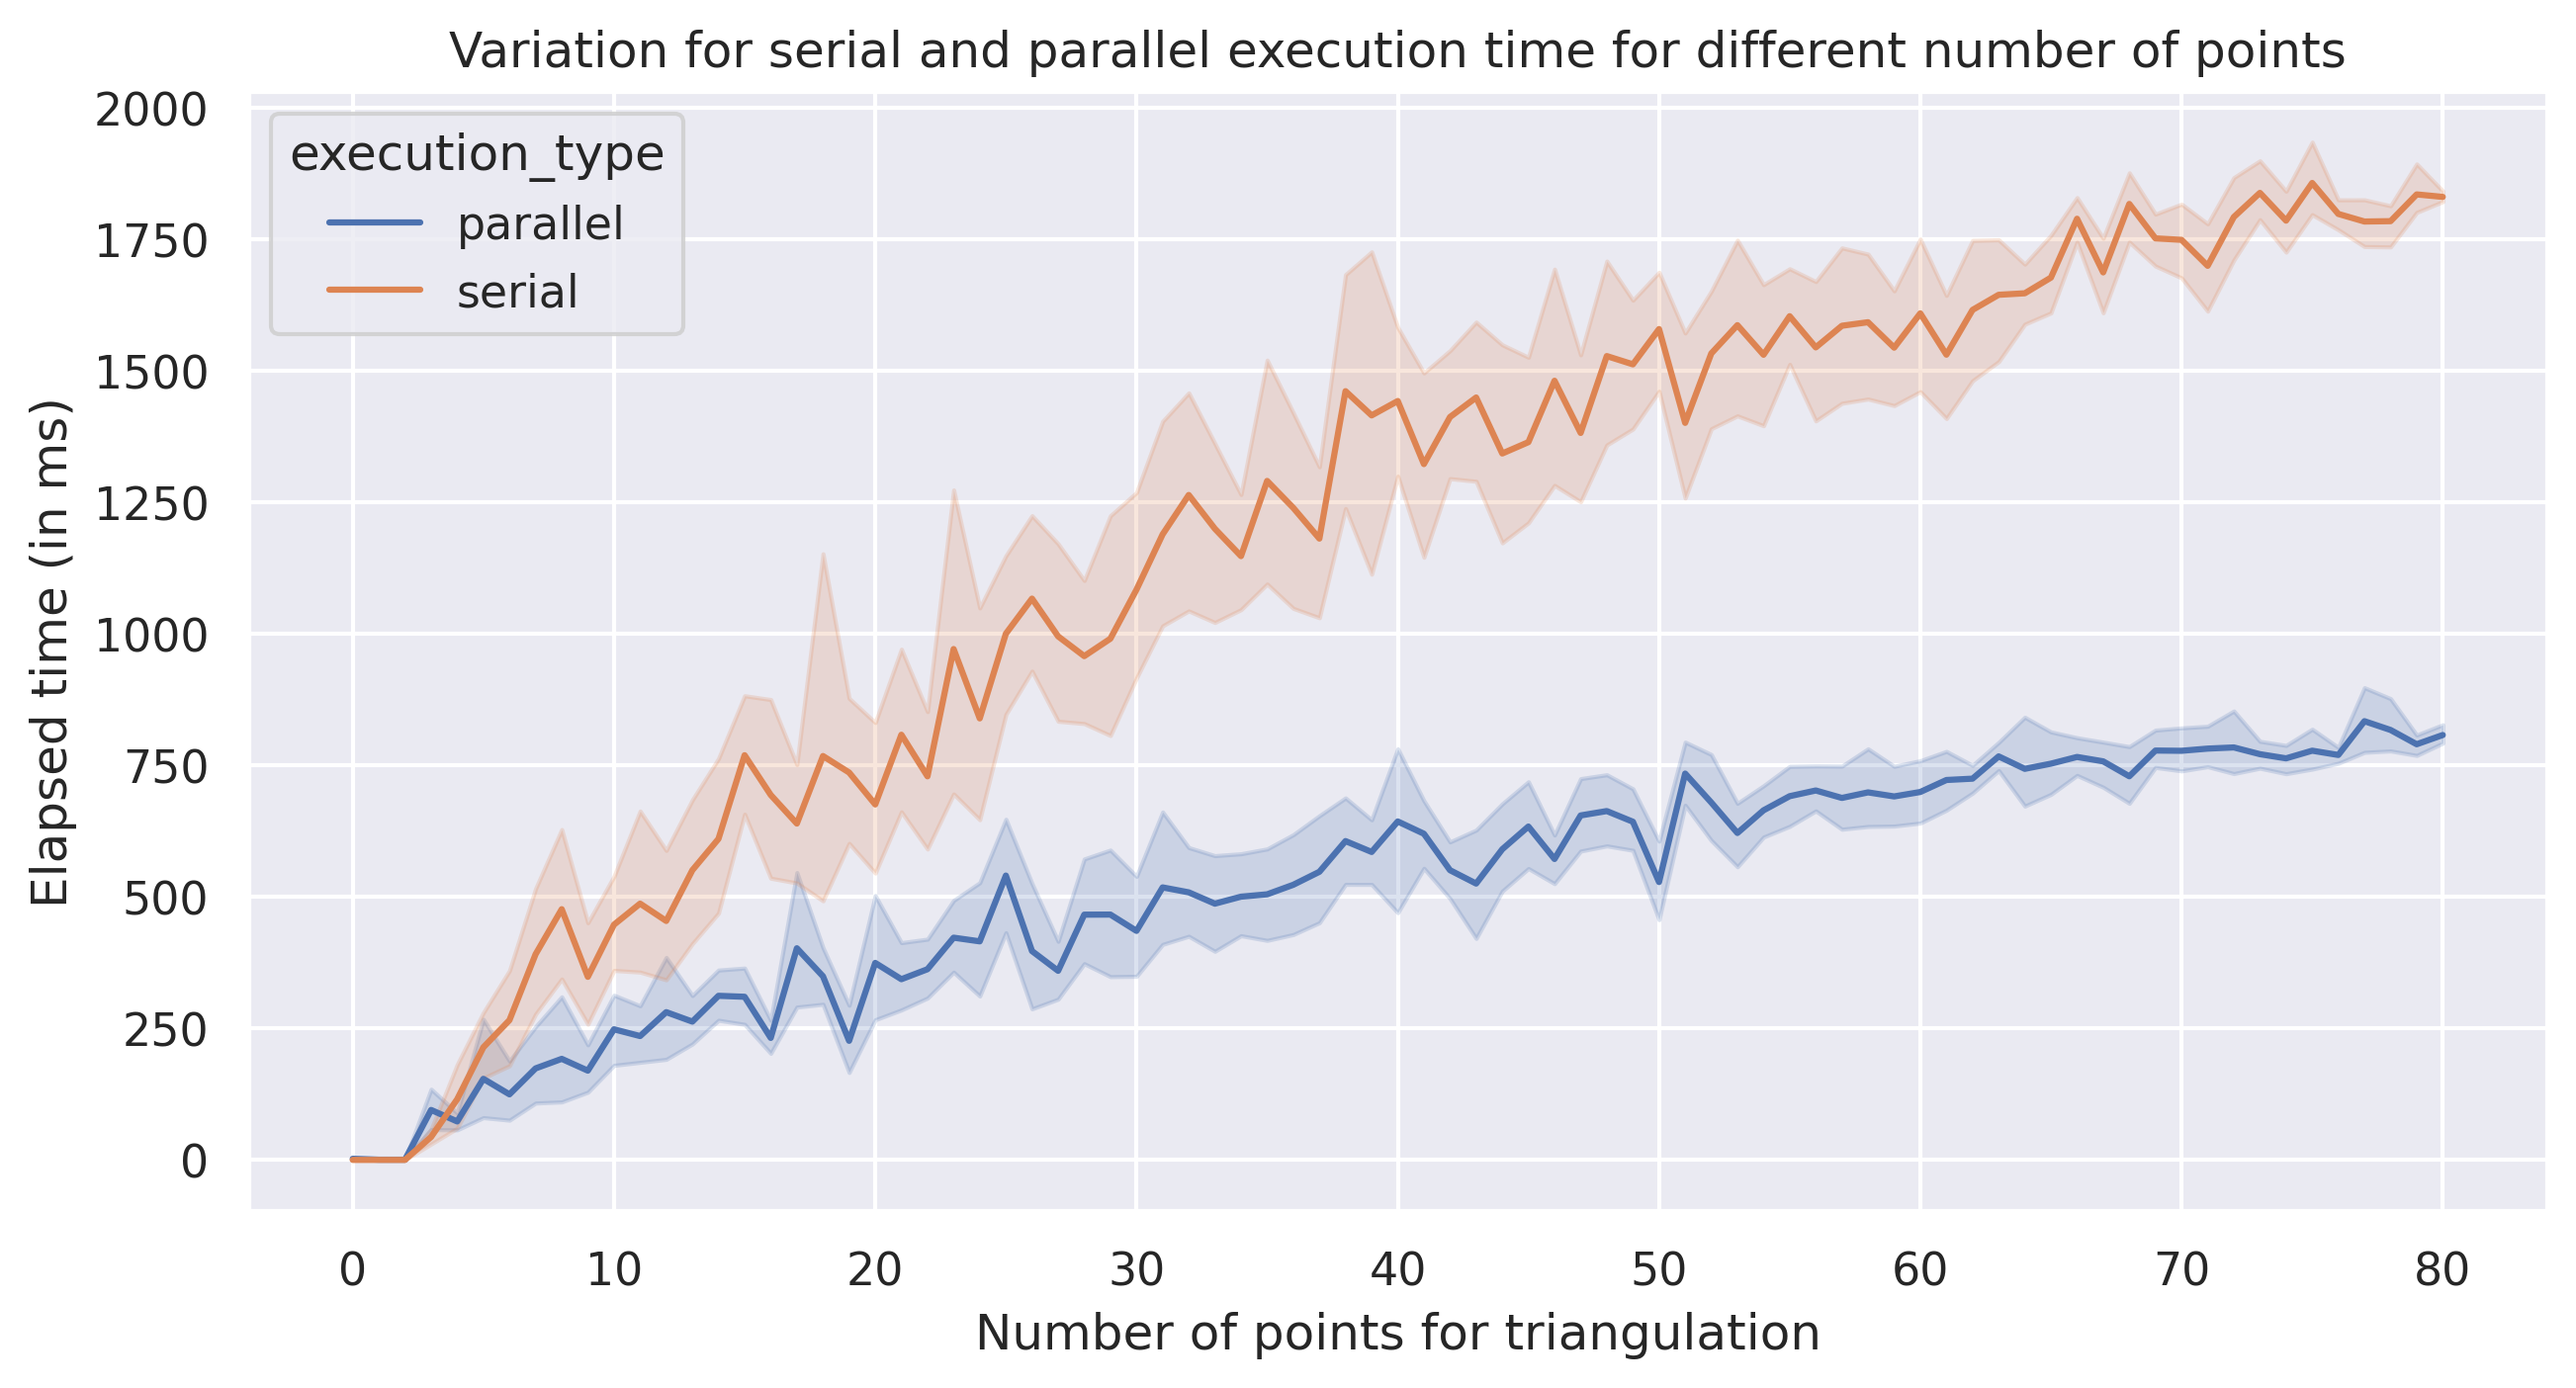

In [57]:
fig, ax = plt.subplots()
sns.lineplot(data=data, x='n_points', y='elapsed_time', hue='execution_type', ax=ax)
ax.set_title('Variation for serial and parallel execution time for different number of points')
ax.set_xlabel('Number of points for triangulation')
ax.set_ylabel('Elapsed time (in ms)')
ax.plot()
fig.savefig('./result/points-vs-elapsedtime.png')

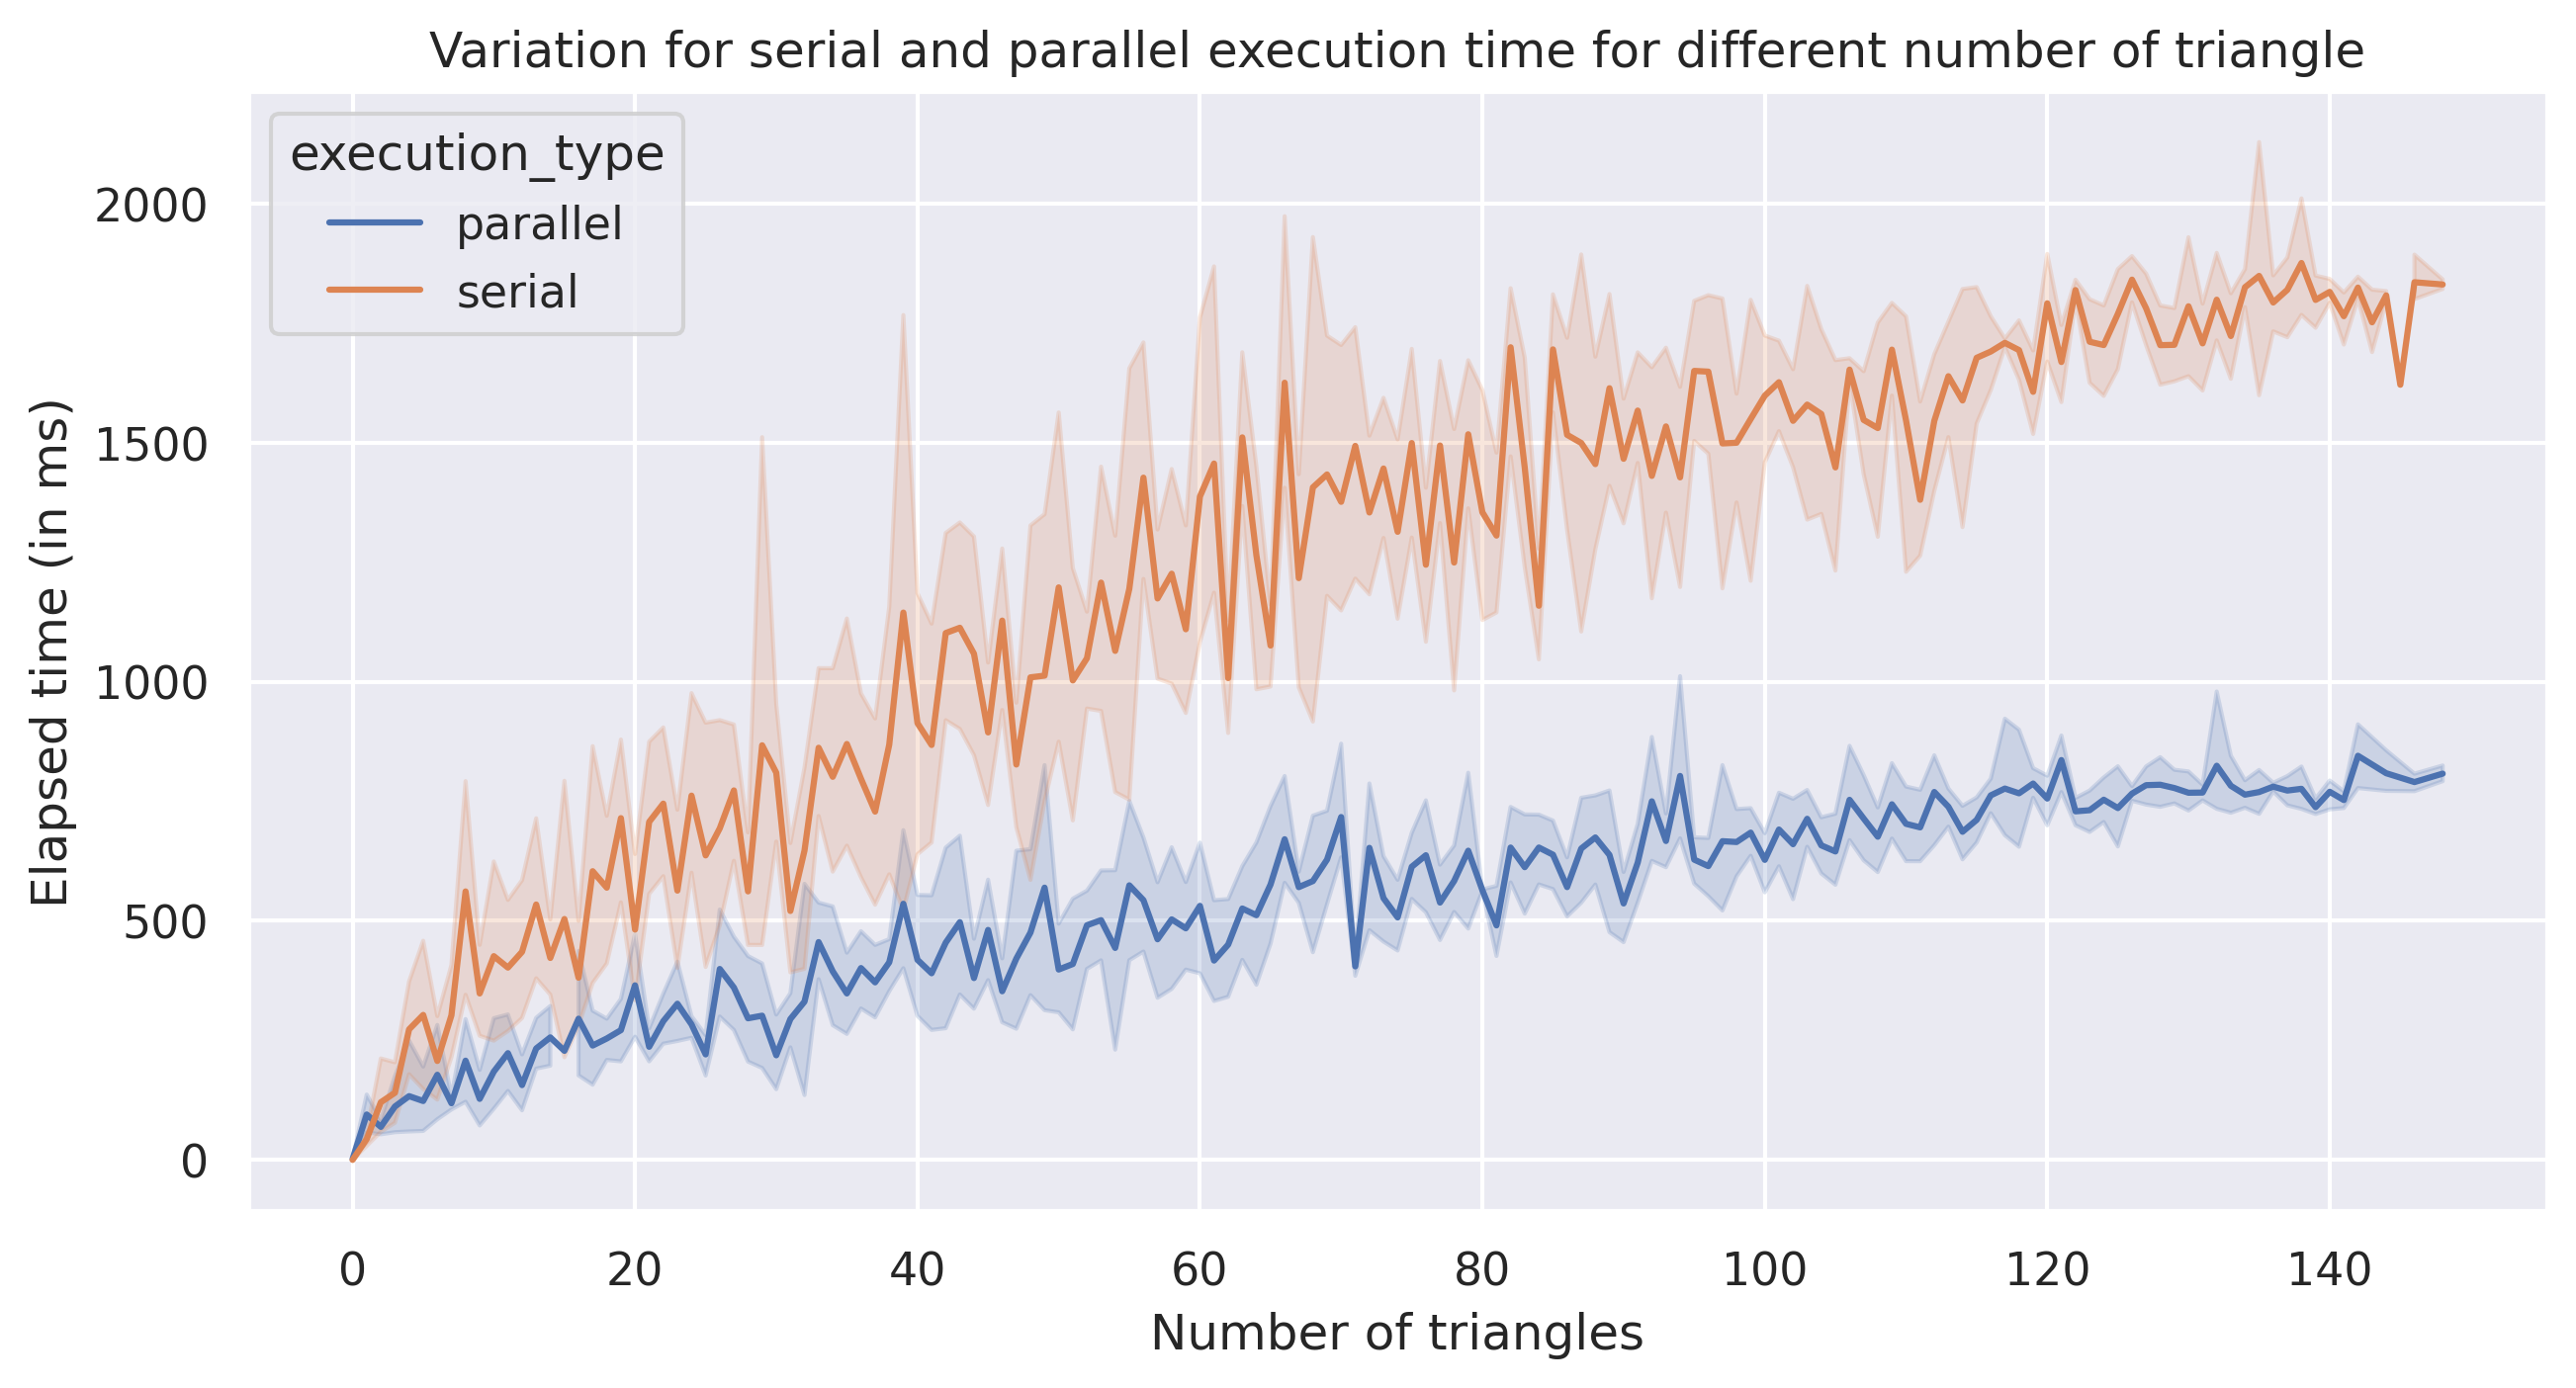

In [56]:
fig, ax = plt.subplots()
sns.lineplot(data=data, x='n_triangles', y='elapsed_time', hue='execution_type', ax=ax)
ax.set_title('Variation for serial and parallel execution time for different number of triangle')
ax.set_xlabel('Number of triangles')
ax.set_ylabel('Elapsed time (in ms)')
ax.plot()
fig.savefig('./result/triangles-vs-elapsedtime.png')